In [10]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import scipy
import utils_dagma
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

In [182]:
def get_block(data, n_nodes=20, index=11):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def fdr_log(data_path, true_path, seed_X, n_jobs):
    # path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_grnboost2/'
    path = data_path
    with open(path + f'W/W_{seed_X}_1_0.pkl', 'rb') as f:
        W = pickle.load(f)
    W = W['W_est']
    Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])
    Z = Z - np.diag(np.diag(Z))
    
    # path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_10_PLS_normX_sym1_disable_norm_grnboost2'
    path = true_path
    with open(path + f'/X/X_{seed_X}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    
    from joblib import Parallel, delayed
    from tqdm import tqdm
    from copy import deepcopy
    fdr=0.2
    num_feat = 100
    est_type = 'tau+'
    n_jobs = 1
    
    print(f"==============================")
    print(f"expected FDR {fdr}")
    
    Z = np.abs(W[:num_feat, :num_feat]) - np.abs(W[num_feat:, :num_feat])
    original_Z = deepcopy(Z)
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    fdr_est_last = 1.
    t_last = np.inf
    
    def _get_t(t_list: list):
        t_last = np.inf
        fdr_est_last = None
        for t in reversed(t_list):
            if t < 0.:
                break
            if est_type == 'tau':
                fdr_est = ((Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            else:
                fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            
            T_T = Z.copy()
            mask = (T_T >= t)
            T_T[mask], T_T[~mask] = 1, 0
            perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
            fdr_true, power = perf['fdr'], perf['tpr']
            print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
            if fdr_est <= fdr:
                t_last = t
                fdr_est_last = fdr_est
        return t_last, fdr_est_last
        
    interval = len(t_list) // n_jobs
    intervals = [(j * interval, (j+1) * interval) for j in range(n_jobs - 1)]
    intervals.append(
        ((n_jobs-1) * interval, len(t_list))
    )
    res1 = []
    res1 = Parallel(n_jobs=n_jobs)(
            delayed(_get_t)(
                t_list[interval[0]:interval[1]]
            ) for interval in intervals
        )
    
    
    res = np.array([list(_res) for _res in res1 if not np.isinf(_res[0]) and _res[1] is not None])
    if len(res) > 0: # otherwise, no edge being selected
        t_last = res[:, 0].min()
        t_last_idx = np.argmin(res[:, 0])
        fdr_est_last = res[t_last_idx, 1]
    
    mask = (Z >= t_last)
    Z[mask], Z[~mask] = 1, 0
    T_T = Z
    
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']
    
    if utils_dagma.is_dag(T_T):
        print("W_est is DAG")
    else:
        print("W_est is NOT DAG")
    print(f"expected fdr {fdr:.1f} | sel thresh {t_last:.4e} | "
          f"est fdr {fdr_est_last:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    print(f"==============================")

[ 167  171  482  944 2075 2516 2767 3511 3542 4409 4425 5473 7127 7181
 7195 8248 9421 9562 9608]
[ 657 1190 2310 3304 4279 4435 4854 5346 5615 5768 6004 7858 8249 8495
 8553 8557 9606 9629 9653]
[1317 1529 1561 3815 3836 4015 4131 4167 4913 5630 5781 6149 6244 6741
 7352 7377 7482 7625 8226]
[ 167  539  925  988 1116 1609 2516 2718 3511 3514 4218 4425 5014 6125
 6610 7195 8110 8970 9772]
[  63  984 1650 1865 1988 4147 5396 5641 5692 6033 6153 7604 7742 8336
 8494 8681 9070 9592 9664]
[  94  640  646  676 1317 1454 2964 3892 4046 4076 5245 5781 6453 6516
 7201 7936 8546 8683 8799]


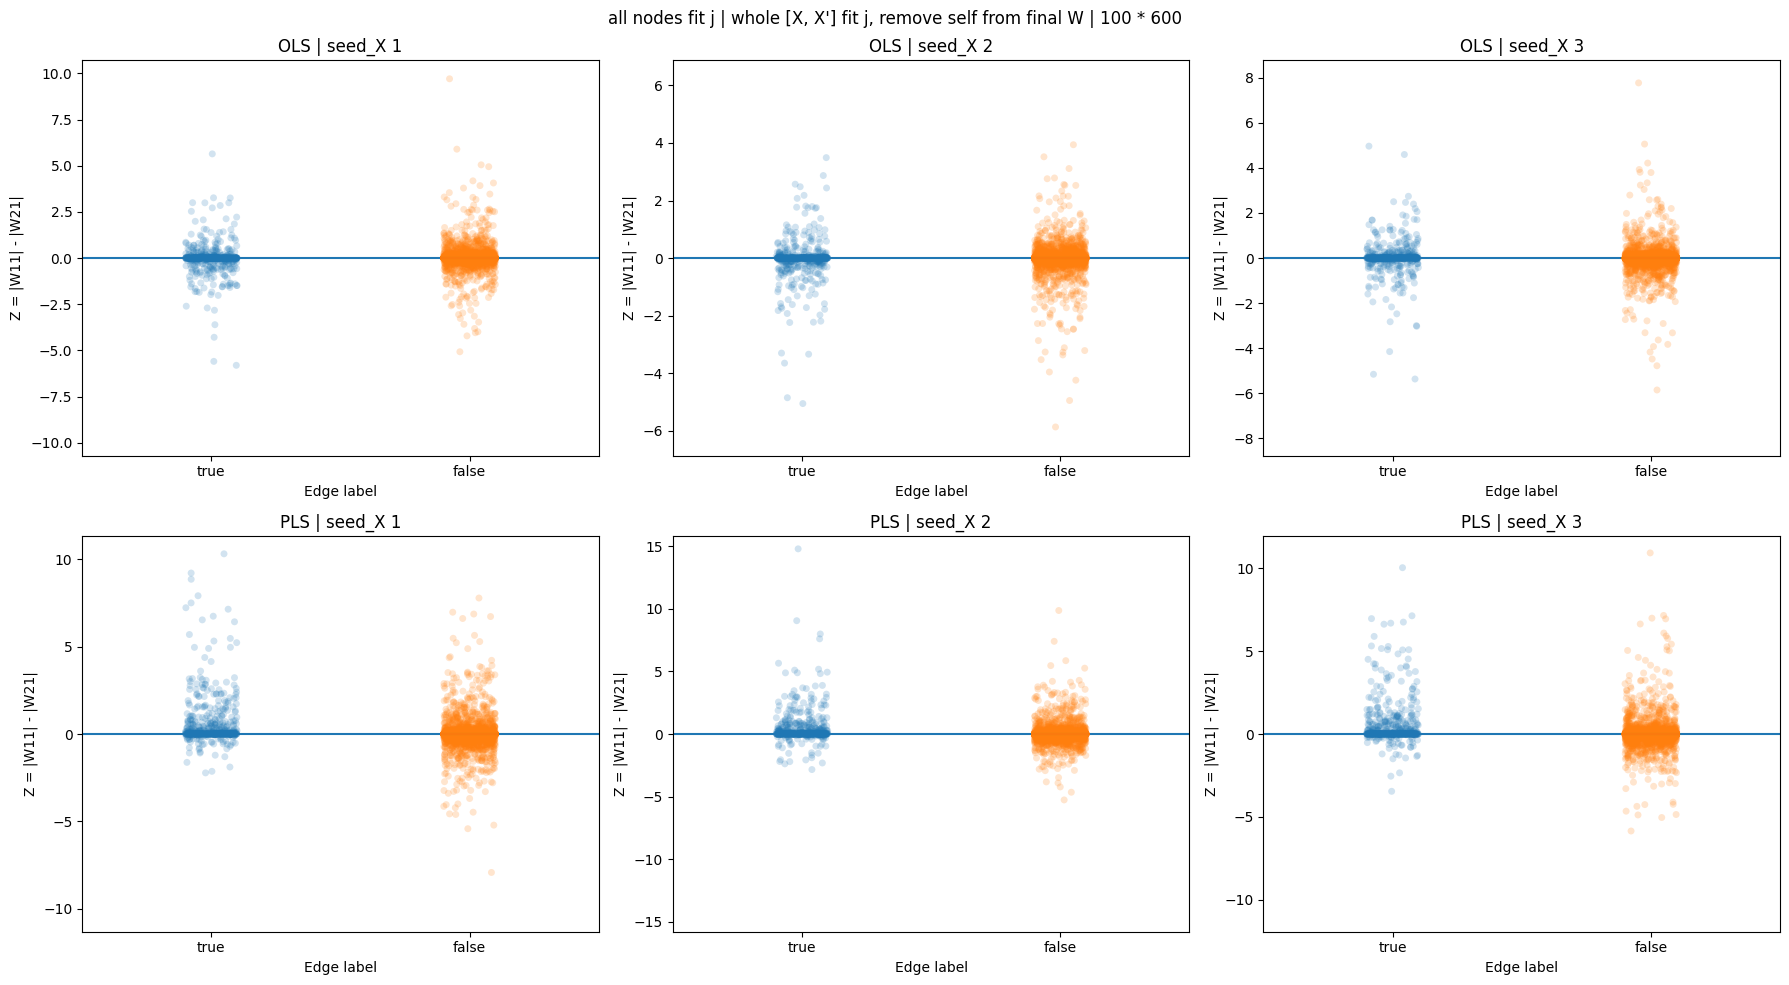

In [323]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i in range(3):
    ax = axs[0][i]
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_5_OLS_disable_remove_self_grnboost2/'
    with open(path + f'W/W_{i+1}_1_0.pkl', 'rb') as f:
        W_full_genie3 = pickle.load(f)
    W_full_genie3 = W_full_genie3['W_est']
    W_full_genie3[:100, :100] = W_full_genie3[:100, :100] - np.diag(np.diag(W_full_genie3[:100, :100]))
    W_full_genie3[100:, :100] = W_full_genie3[100:, :100] - np.diag(np.diag(W_full_genie3[100:, :100]))
    Z = np.abs(W_full_genie3[:100, :100]) - np.abs(W_full_genie3[100:, :100])
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_10_PLS_topo_sort'
    with open(path + f'/X/X_{i+1}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    B_true = (W_true != 0)
    data = {
        'true': Z[B_true].flatten(),
        'false': Z[~B_true].flatten(),
    }
    ax = sns.stripplot(data, ax=ax, alpha=0.2)
    ax.set_title(f"OLS | seed_X {i+1}")
    ax.set_xlabel("Edge label")
    ax.set_ylabel("Z = |W11| - |W21|")
    ax.set_ylim(-np.abs(Z).max()-1, np.abs(Z).max()+1)
    ax.axhline(0)

    B_true = (W_true != 0.)
    out_deg = B_true.sum(1)
    in_deg = B_true.sum(0)
    
    Z_null = Z[~B_true]
    Z_null_sort = np.sort(Z_null.flatten())
    
    src_list, dst_list = [], []
    edge_list = []
    for i in range(1, 20, 1):
        src_list.append(
            np.where(Z == Z_null_sort[-i])[0]
        )
        dst_list.append(
            np.where(Z == Z_null_sort[-i])[1]
        )
        edge_list.append(
            (np.where(Z == Z_null_sort[-i])[0] * 100 + np.where(Z == Z_null_sort[-i])[1])[0]
        )
    edge_list = np.sort(edge_list)
    print(edge_list)
    
    

for i in range(3):
    ax = axs[1][i]
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_5_PLS_disable_remove_self_grnboost2/'
    with open(path + f'W/W_{i+1}_1_0.pkl', 'rb') as f:
        W_full_genie3 = pickle.load(f)
    W_full_genie3 = W_full_genie3['W_est']
    W_full_genie3[:100, :100] = W_full_genie3[:100, :100] - np.diag(np.diag(W_full_genie3[:100, :100]))
    W_full_genie3[100:, :100] = W_full_genie3[100:, :100] - np.diag(np.diag(W_full_genie3[100:, :100]))
    Z = np.abs(W_full_genie3[:100, :100]) - np.abs(W_full_genie3[100:, :100])
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_10_PLS_topo_sort'
    with open(path + f'/X/X_{i+1}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    B_true = (W_true != 0)
    data = {
        'true': Z[B_true].flatten(),
        'false': Z[~B_true].flatten(),
    }
    ax = sns.stripplot(data, ax=ax, alpha=0.2)
    
    ax.set_title(f"PLS | seed_X {i+1}")
    ax.set_xlabel("Edge label")
    ax.set_ylabel("Z = |W11| - |W21|")
    ax.set_ylim(-np.abs(Z).max()-1, np.abs(Z).max()+1)
    ax.axhline(0)

    B_true = (W_true != 0.)
    out_deg = B_true.sum(1)
    in_deg = B_true.sum(0)
    
    Z_null = Z[~B_true]
    Z_null_sort = np.sort(Z_null.flatten())
    
    src_list, dst_list = [], []
    edge_list = []
    for i in range(1, 20, 1):
        src_list.append(
            np.where(Z == Z_null_sort[-i])[0]
        )
        dst_list.append(
            np.where(Z == Z_null_sort[-i])[1]
        )
        edge_list.append(
            (np.where(Z == Z_null_sort[-i])[0] * 100 + np.where(Z == Z_null_sort[-i])[1])[0]
        )
    edge_list = np.sort(edge_list)
    print(edge_list)
    
plt.suptitle(f"all nodes fit j | whole [X, X'] fit j, remove self from final W | 100 * 600")
plt.tight_layout()

Text(0.5, 1.0, "out/in degree of src/dst nodes of null edges \n selected null edges have top-20 Z value\n100 * 600 | PLS | seed_X=3 | all nodes fit j | whole [X, X'] fit j, remove self from final W")

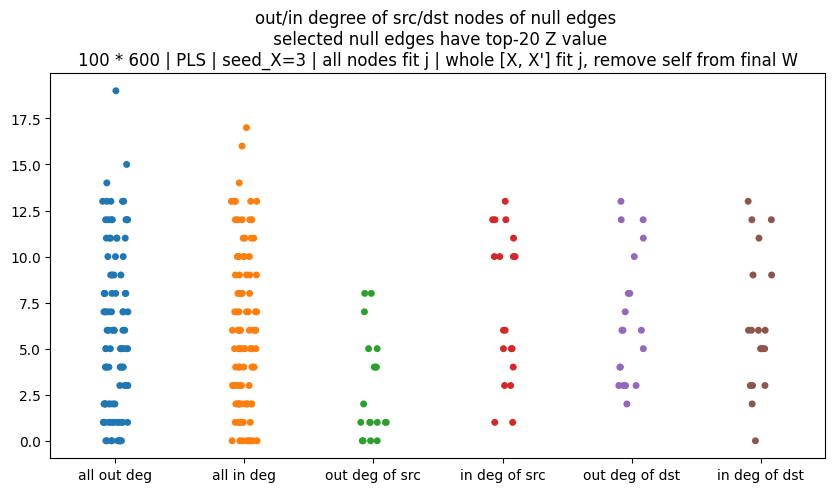

In [350]:
B_true = (W_true != 0.)
out_deg = B_true.sum(1)
in_deg = B_true.sum(0)

Z_null = Z[~B_true]
Z_null_sort = np.sort(Z_null.flatten())

src_list, dst_list = [], []
for i in range(1, 20, 1):
    src_list.append(
        np.where(Z == Z_null_sort[-i])[0]
    )
    dst_list.append(
        np.where(Z == Z_null_sort[-i])[1]
    )
src_list, dst_list = np.array(src_list).flatten(), np.array(dst_list).flatten()

out_deg_src, in_deg_src, out_deg_dst, in_deg_dst = [], [], [], []
for src, dst in zip(src_list, dst_list):
    out_deg_src.append(out_deg[src])
    in_deg_src.append(in_deg[src])
    out_deg_dst.append(out_deg[dst])
    in_deg_dst.append(in_deg[dst])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = {
    'all out deg': out_deg,
    'all in deg': in_deg,
    'out deg of src': out_deg_src,
    'in deg of src': in_deg_src,
    'out deg of dst': out_deg_dst,
    'in deg of dst': in_deg_dst,
}

sns.stripplot(data, ax=ax)
plt.title("out/in degree of src/dst nodes of null edges \n selected null edges have top-20 Z value\n"
          "100 * 600 | PLS | seed_X=3 | all nodes fit j | whole [X, X'] fit j, remove self from final W")

Text(0.5, 1.0, "out/in degree of src/dst nodes of null edges \n selected null edges have top-100 Z value\n100 * 600 | PLS | seed_X=3 | all nodes fit j | whole [X, X'] fit j, remove self from final W")

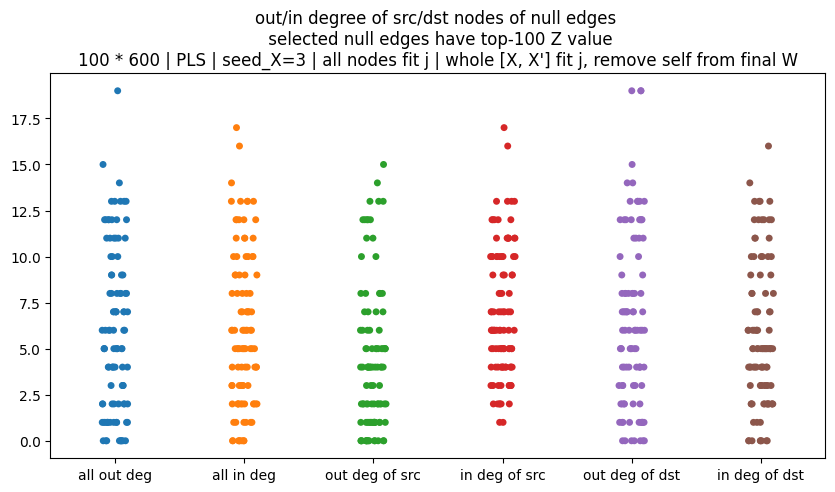

In [347]:
B_true = (W_true != 0.)
out_deg = B_true.sum(1)
in_deg = B_true.sum(0)

Z_null = Z[~B_true]
Z_null_sort = np.sort(Z_null.flatten())

src_list, dst_list = [], []
for i in range(1, 100, 1):
    src_list.append(
        np.where(Z == Z_null_sort[-i])[0]
    )
    dst_list.append(
        np.where(Z == Z_null_sort[-i])[1]
    )
src_list, dst_list = np.array(src_list).flatten(), np.array(dst_list).flatten()

out_deg_src, in_deg_src, out_deg_dst, in_deg_dst = [], [], [], []
for src, dst in zip(src_list, dst_list):
    out_deg_src.append(out_deg[src])
    in_deg_src.append(in_deg[src])
    out_deg_dst.append(out_deg[dst])
    in_deg_dst.append(in_deg[dst])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = {
    'all out deg': out_deg,
    'all in deg': in_deg,
    'out deg of src': out_deg_src,
    'in deg of src': in_deg_src,
    'out deg of dst': out_deg_dst,
    'in deg of dst': in_deg_dst,
}

sns.stripplot(data, ax=ax)
plt.title("out/in degree of src/dst nodes of null edges \n selected null edges have top-100 Z value\n"
          "100 * 600 | PLS | seed_X=3 | all nodes fit j | whole [X, X'] fit j, remove self from final W")

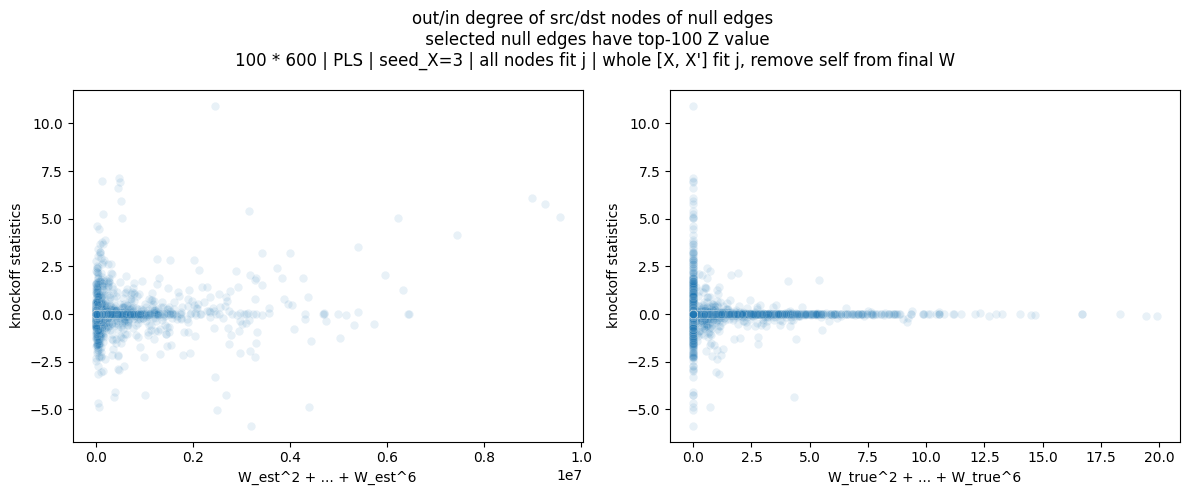

In [341]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
X = 0
mask = ~B_true
for i in range(2, 6, 1):
    X += np.linalg.matrix_power(np.abs(W_full_genie3), i)
X = X[:100, :100]
data = {
    'W_est^2 + ... + W_est^6': X[mask],
    'knockoff statistics': Z[mask]
}
sns.scatterplot(
    data, x='W_est^2 + ... + W_est^6', y='knockoff statistics',
    alpha=0.1, ax=ax
)

ax = axs[1]
X = 0
mask = ~B_true
for i in range(2, 6, 1):
    X += np.linalg.matrix_power(np.abs(W_true), i)
X = X[:100, :100]
data = {
    'W_true^2 + ... + W_true^6': X[mask],
    'knockoff statistics': Z[mask]
}
sns.scatterplot(
    data, x='W_true^2 + ... + W_true^6', y='knockoff statistics',
    alpha=0.1, ax=ax
)


plt.suptitle("out/in degree of src/dst nodes of null edges \n selected null edges have top-100 Z value\n"
          "100 * 600 | PLS | seed_X=3 | all nodes fit j | whole [X, X'] fit j, remove self from final W")
plt.tight_layout()

<Axes: xlabel='W estimated by grnboost2', ylabel='knockoff statistics'>

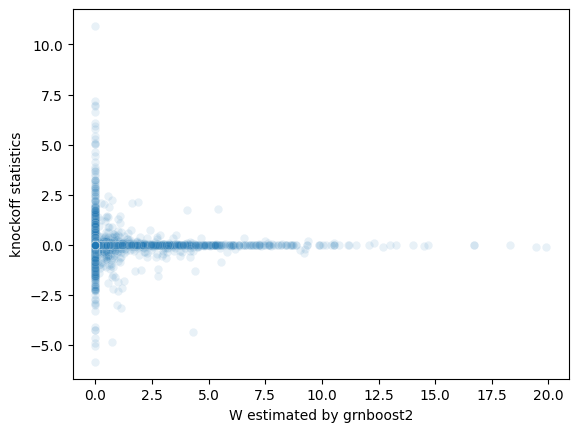

In [334]:
X = 0
mask = ~B_true
for i in range(2, 6, 1):
    X += np.linalg.matrix_power(np.abs(W_true), i)
X = X[:100, :100]
data = {
    'W estimated by grnboost2': X[mask],
    'knockoff statistics': Z[mask]
}
sns.scatterplot(
    data, x='W estimated by grnboost2', y='knockoff statistics',
    alpha=0.1
)


# compare model performance

In [361]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v48/100_600/W_100_600_1_0_normX_sym1_grnboost2.pkl'
with open(path, 'rb') as f:
    W_grnboost2 = pickle.load(f)

path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v39/100_600/W_100_600_1_0_normX_sym1.pkl'
with open(path, 'rb') as f:
    W_dagma = pickle.load(f)

path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v100_600_normX_sym1/'
with open(path + f'X/X_1.pkl', 'rb') as f:
    true_data = pickle.load(f)
X = true_data['X']
W_true = true_data['W_true']
B_true = (W_true != 0)

In [374]:
aupr_grns, auroc_grns, aupr_dags, auroc_dags = \
    [], [], [], []

for j in range(100):
    W_grn_j = W_grnboost2[:, j]
    W_dag_j = W_dagma[:, j]
    true_j = B_true[:, j]
    tag = False

    prec, rec, threshold = precision_recall_curve(true_j, np.abs(W_grn_j))
    aupr_grn =  auc(rec, prec)
    try:
        auroc_grn = roc_auc_score(true_j, np.abs(W_grn_j))
    except ValueError:
        tag = True

    prec, rec, threshold = precision_recall_curve(true_j, np.abs(W_dag_j))
    aupr_dag =  auc(rec, prec)
    try:
        auroc_dag = roc_auc_score(true_j, np.abs(W_dag_j))
    except ValueError:
        tag = True

    
    
    if tag:
        print(f"{j} | {aupr_grn:.4f}, only type {true_j[0]} | {aupr_dag:.4f}, only type {true_j[0]}")
    else:
        aupr_grns.append(aupr_grn)
        aupr_dags.append(aupr_dag)
        auroc_grns.append(auroc_grn)
        auroc_dags.append(auroc_dag)
        print(f"{j} | {aupr_grn:.4f}, {auroc_grn:.4f} | {aupr_dag:.4f}, {auroc_dag:.4f}")
    

0 | 0.2638, 0.6553 | 0.8502, 0.8962
1 | 0.2343, 0.6190 | 0.8689, 0.9438
2 | 1.0000, 1.0000 | 1.0000, 1.0000
3 | 0.3208, 0.7366 | 0.9455, 0.9939
4 | 0.1688, 0.6325 | 1.0000, 1.0000
5 | 0.5150, 0.7905 | 1.0000, 1.0000
6 | 0.5000, only type False | 0.5000, only type False
7 | 0.5000, only type False | 0.5000, only type False
8 | 0.3877, 0.8192 | 0.9189, 0.9111
9 | 0.3104, 0.7128 | 1.0000, 1.0000
10 | 0.1361, 0.7643 | 0.9437, 0.9974
11 | 0.1667, 0.5455 | 0.8659, 0.8939
12 | 0.4199, 0.7268 | 1.0000, 1.0000
13 | 0.3547, 0.7996 | 0.8449, 0.8688
14 | 0.1423, 0.6300 | 0.9826, 0.9978
15 | 0.7280, 0.9622 | 1.0000, 1.0000
16 | 0.2458, 0.6222 | 0.8701, 0.9214
17 | 0.4410, 0.9375 | 1.0000, 1.0000
18 | 0.1086, 0.6170 | 1.0000, 1.0000
19 | 0.2021, 0.7908 | 0.8591, 0.9443
20 | 0.1383, 0.9286 | 1.0000, 1.0000
21 | 0.5000, only type False | 0.5000, only type False
22 | 0.1755, 0.7400 | 0.8146, 0.8800
23 | 1.0000, 1.0000 | 1.0000, 1.0000
24 | 0.6625, 0.9847 | 0.5253, 0.8571
25 | 0.1093, 0.6318 | 1.0000, 1

/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/

Text(0.5, 0.98, '100 * 600, seed=1, PLS | AUROC of each task')

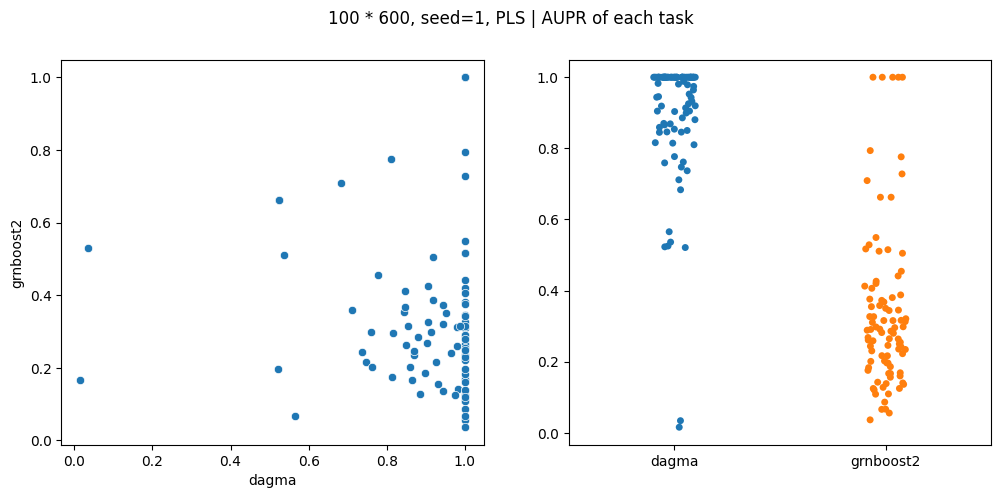

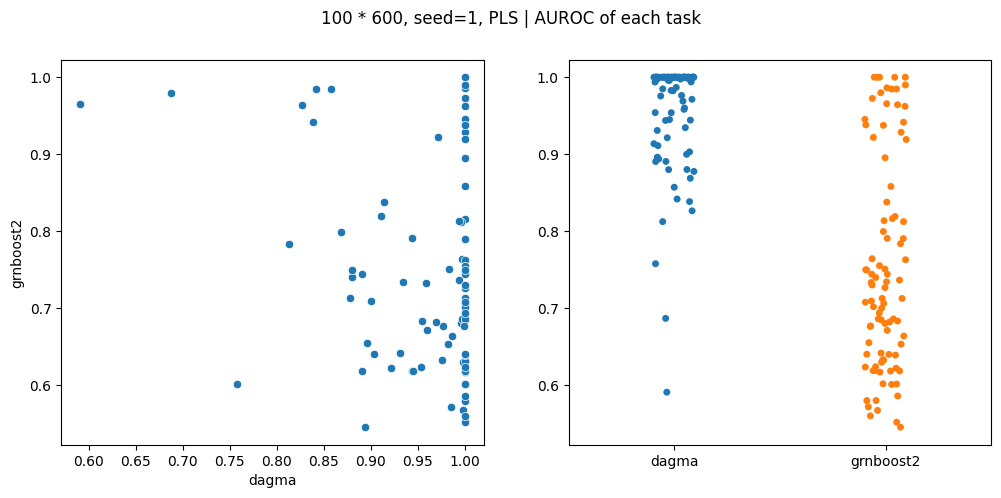

In [384]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
data = {
    'dagma': aupr_dags,
    'grnboost2': aupr_grns
}
sns.scatterplot(
    data, x='dagma', y='grnboost2', ax=ax
)

ax = axs[1]
data = {
    'dagma': aupr_dags,
    'grnboost2': aupr_grns
}
sns.stripplot(
    data
)
plt.suptitle("100 * 600, seed=1, PLS | AUPR of each task")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
data = {
    'dagma': auroc_dags,
    'grnboost2': auroc_grns
}
sns.scatterplot(
    data, x='dagma', y='grnboost2', ax=ax
)

ax = axs[1]
data = {
    'dagma': auroc_dags,
    'grnboost2': auroc_grns
}
sns.stripplot(
    data
)
plt.suptitle("100 * 600, seed=1, PLS | AUROC of each task")